#Intro and Glossary


###Methods Used:

I decided to try to do a quick analysis on this Sixers team. It's been a fun season, and hopefully they'll make a deep run in the playoffs. 

\**As the first aside of what will surely be many throughout this analysis, a Jupyter Notebook probably wasn't the best way to do this analysis as far as making it readable for 5 people who will probably end up looking through this. I did my best to format it to make it somewhat coherent. I will put analysis/thoughts for each chart immediately after it.\**


###Glossary:

######usg_rtg 
Usage Rating, is an estimate of the percentage of team plays used by a player while he was on the floor. In short, if a players Usage Rating is 30% this means they are finishing 30% of their teams possession(i.e. taking a a shot, turning the ball over, getting to the free throw line). Higher the usage rating, the larger part of the offense the player is.

######ts_pct 
True Shooting Percentage, the formula is PTS / (2 * (FGA+(.44*FTA)). True shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws. The league average here is about 56%, once you get into the 60s you're looking at elite efficiency from the field.

######bpm 
Box Plus Minus, a box score estimate of the points per 100 possessions that a player contributed above a league-average player, translated to an average team. Per Basketball Reference they describe the scale as follows 10.0 is an all-time season, 8.0 is an MVP season, and 6.0 is an all-NBA season. There's quite a bit that goes into calculating this stat just know that it uses almost every countable statistic and that it adjusts for amount of time played.

######ws
Win Shares, is a player statistic which attempts to divvy up credit for team success to the individuals on the team. This is similar to BPM in that it is basically a composite of many different metrics to try to calculate how much impact a player has. My understanding to the difference between the two is that Win Shares only looks at how much impact you have compared to all of the players on your particular team, while BPM will look at how much impact you have compared to every player in the league

######ws_per_48
Win Shares per 48 minutes, is just a way to control Win Shares for minutes played. Having above a .25 in this category means that player is having a MVP worthy season.

######Ortg
Offensive Rating, this is used to show how many points a team scores per 100 possessions. This year the Nets lead the league in Ortg at 117. The league median comes in at 111.5.

######Drtg
Defensive Rating, this is used to show how many points a team gives up per 100 possession. This year the Lakers and Sixers are tied for the league lead at 106.8. The league median comes in at 111.7.

######Net_rating
Net Rating, This is calculated through subtracting Ortg by Drtg. A positive number means you are scoring more points per 100 possessions than you are giving up. This year the Jazz lead the league at 9. The league median comes in at .7.

######stocks_per_g
Stocks per Game, this is stat that simply consolidates Steals and Blocks into a single stat. Bill Simmons used this pretty frequently throughout his Book of Basketball and I am stealing it.


# How Does This Sixers Team Compare to Team's of Past


This Sixer's team has been one of the better team's in the league for the majority of the season. When Joel Embiid and Ben Simmons are healthy this team will have no problem winning regular season games. The Sixers have had a winning percentage of above 60% for 3 of the past 4 seasons. They had done that just 1 time in the 27 seasons prior(H/t Derek Bodner). 

Will this team's regular season success translate into the playoffs? Or will the slower pace and better prepared defenses expose holes in this team's roster?


I tried comparing some of this team's more macro stats to past Sixers team and also to other teams in the league who had playoff success. 






In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import statsmodels.api as sm
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeRegressor

os.chdir('/Users/matthewhartz/python_practice/projects/sixers_2021_playoffs')

mvp_seasons = pd.read_excel('data/mvp_votings.xlsx')
teams = pd.read_csv('data/Team_Records.csv')

In [17]:
teams['net_rating'] = teams['Ortg']-teams['DRtg']
teams['Team'] = teams['Team'].str.replace('*', '')
teams['Date'] = teams['Season'].str[:4].astype(int)+1
teams['Playoffs'].fillna('Did not make Playoffs', inplace=True)
teams['champs'] = teams['Playoffs'].apply(lambda row: 1 if row=='Won Finals' else 0)  
teams['21 Sixers'] = 0
teams.at[6, '21 Sixers'] = 1
teams['champs_and_sixers'] = 0
teams['champs_and_sixers'] = teams['Playoffs'].apply(lambda row: 1 if row=='Won Finals' else 0)
teams['finals_contenders'] = teams['Playoffs'].apply(lambda row: 1 if row in('Won Finals', 'Lost Finals') else 0)
teams.at[6,'champs_and_sixers']= 1
teams.at[6,'finals_contenders']= 1

sixers_df = teams[(teams.Team=="Philadelphia 76ers")&(teams.Date>2000)]
sixers_df

finals_contenders = teams[(teams.finals_contenders==1)&(teams.Date>1990)]
champs_and_sixers = teams[(teams.champs_and_sixers==1)&(teams.Date>1990)]

mvp_seasons['mvp_winner'] = 0
for season in mvp_seasons['season'].value_counts().index:
    temp_df = mvp_seasons[mvp_seasons['season'].isin([season])]
    index=[temp_df['points_won'].idxmax()]
    mvp_seasons.at[index, 'mvp_winner'] = 1

mvp_seasons['embiid_tag'] = 0
mvp_seasons.at[637,'embiid_tag']= 1
mvp_seasons['embiid'] = 'Other'
mvp_seasons.at[637, 'embiid'] = 'Embiid'
mvp_seasons['stocks_per_g'] = mvp_seasons['stl_per_g']+mvp_seasons['blk_per_g']
mvp_seasons['embiid_and_mvps'] = mvp_seasons['embiid_tag'].apply(lambda row: 1 if row==1  else 0)
mvp_seasons['embiid_and_mvps'] = mvp_seasons['mvp_winner'].apply(lambda row: 1 if row==1  else 0)
mvp_seasons['team_wins'] = mvp_seasons['win_pct'].apply(lambda row: round(82 * row))

big_man_contemporaries = ['Moses Malone', 'Karl Malone','''Shaquille O'neal''', 'Patrick Ewing', 
                         'Tim Duncan', 'Kevin Garnett', 'Dirk Nowitzki', 'Hakeem Olajuwon', 'Charles Barkley',
                         'Dwight Howard', 'Nikola Jokic', 'Joel Embiid', 'Yao Ming', 'Tyson Chandler', 
                         'Marc Gasol','Anthony Davis']

mvp_seasons['big_man'] = mvp_seasons['player'].apply(lambda row: 1 if row in big_man_contemporaries else 0)
mvps_and_embiid=mvp_seasons[(mvp_seasons.mvp_winner==1)|(mvp_seasons.embiid_tag==1)]
big_men = mvp_seasons[(mvp_seasons.big_man==1)]

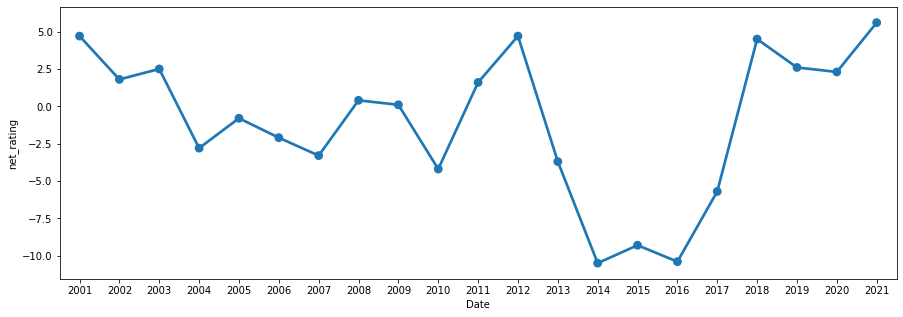

In [28]:
fig, ax =plt.subplots(1,1, sharex=True, figsize=(15,5))
sns.pointplot(x='Date', y='net_rating', data=sixers_df)
plt.show()

This Sixer's team put up the best Net Rating the franchise has seen in the last 20 years, and the best since the Doc & Moses teams of the early 80s. The Sixer's net rating of 5.5 ranked 5th in the league this year behind the Jazz, Clippers, Suns, and Bucks. 



\**Man oh man does this really highlight how bad those Process teams were. Hard to say if it was worth it though. If the Sixers never tanked, I'm sure it would've been a lot of fun to watch Luke Kennard hit 7 threes to lift the Sixers over the Pacers in the play-in game so the Sixers could get the honor of being swept by Brooklyn.*\*

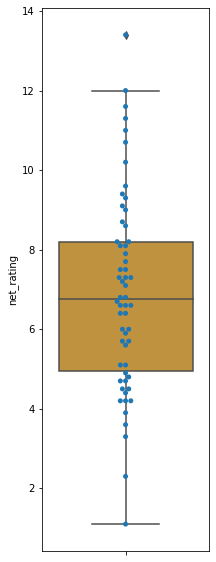

In [29]:
fig, ax =plt.subplots(1,1, sharex=True, figsize=(3,10))
sns.boxplot(y=finals_contenders['net_rating'], color= "orange", saturation=.5)
sns.swarmplot(y=finals_contenders['net_rating'], hue=finals_contenders['21 Sixers'])
plt.show()

In [ ]:
#make histogram
median_net_finals_teams = finals_contenders['net_rating'].median()

print(median_net_finals_teams)



#EmVP

One prerequisite for almost every champion in league history is having a top MVP candidate. Of course there are a few exceptions, but having an MVP candidate is what separates the contenders from the pretenders. This is great news for the Sixers because for the first time in 20 years they will have an MVP finalist in Joel Embiid. While Joel is fairly unlikely to be named MVP due to the amount of games played, the impact he has while on the floor is undeniably worthy of consideration. 

Joel and Sixers fans have set their eyes on a different trophy, and as long as JoJo stays on the floor the Sixers can consider themselves contenders.

##Was Joel's Season MVP Worthy?

Embiid has had an unreal season, and has obviously been the driving factor behind this team's success. Unfortunately, due to the amount of games missed it is unlikely voters will make him the first Sixer player to win MVP since Allen Iverson in 2001. 

To help grasp just how crazy Embiid's season has been I took a look at each individual season that garnered an MVP vote since 1981. So this dataset includes all the MVP winners and runners-up. In the 80s and 90s, usually there was around 15-20 players to receive a vote. In recent years I know the media is allowed to put just 5 players on their ballot. So this translates to somewhere around 10-12 players receiving a vote.

The first chart I wanted to use to show Embiid's impact was a graph of Usage Rate and True Shooting %. 

\**If you need a refresher on these metrics refer to the GLOSSARY section at the beginning of this analysis*\*

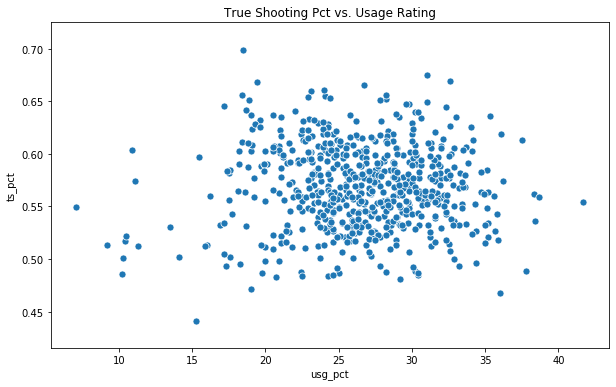

In [7]:
fig, ax =plt.subplots(1,1, sharex=True, figsize=(10,6))
sns.scatterplot(mvp_seasons['usg_pct'],mvp_seasons['ts_pct'], s=50)
ax.set_title('True Shooting Pct vs. Usage Rating')
plt.show()

I've included every player in this first chart to mask where Embiid ended up. The closer to the top right, the more efficient and part of the offense the player is.

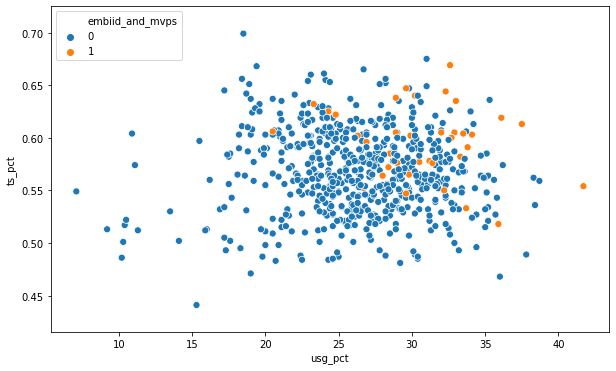

In [8]:
fig, ax =plt.subplots(1,1, sharex=True, figsize=(10,6))
sns.scatterplot(mvp_seasons['usg_pct'],mvp_seasons['ts_pct'],hue=mvp_seasons['embiid_and_mvps'], s=50)
ax.legend(loc='upper left')
plt.show()

If we now color in all of the players who won an MVP and Embiid, we can see that many of those players end up in the top right quadrant. Now the question is which one do you think is Joel?

Now let's get rid of all those non-MVPs and see what we're left with. Embiid is as high up there as anyone else. His efficieny this season, driver largely by his ability to get to the line, we elite. And he was as instrumental to the offense as any other MVP.

Now here comes the caveat. Did Embiid just have one of the best seasons of all time? Probably not. Modern teams and players have the benefit of a faster pace, knowing which shots are the most efficient on the floor, and running a spacious offensive system. That's not to say Embiid didn't dominate, but if players like Hakeem or Shaq had the benefit of this era's spacing and movement they probably would've end up a little higher on the chart.

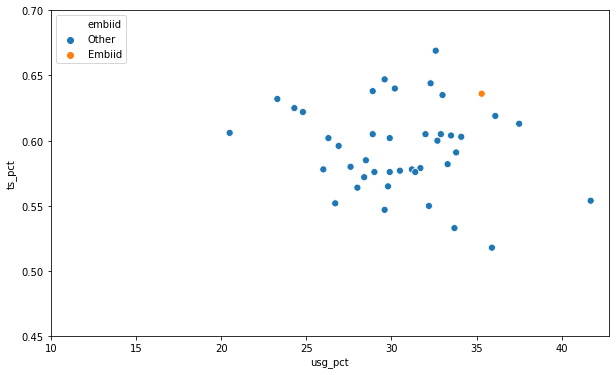

In [9]:
fig, ax =plt.subplots(1,1, sharex=True, figsize=(10,6))
sns.scatterplot(mvps_and_embiid['usg_pct'], mvp_seasons['ts_pct'], hue= mvps_and_embiid['embiid'], s=50)
ax.set(xticks=[5*i for i in range(2,9)])
ax.set(yticks=[.05*i for i in range(9,15)])
ax.legend(loc='upper left')
plt.show()

Embiid's efficieny was remarkable, but what about his other numbers. How did he compare to some of the other big men who've competed for MVP awards? In this chart we'll look at just big men and a few different statistics: Points, Rebounds, Stocks, Free throws attempt.

*Note all of these stats are on a per game basis

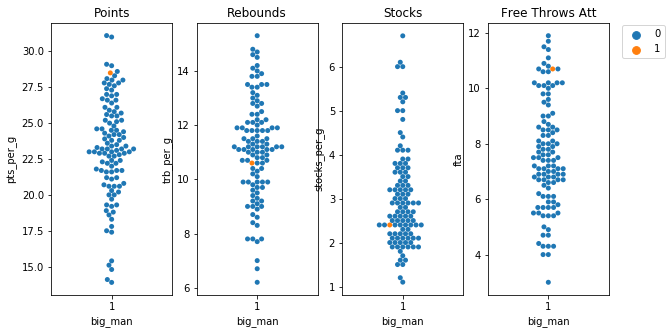

In [10]:
fig, ax =plt.subplots(1,4, sharex=True, figsize=(10,5))
sns.swarmplot(ax=ax[0],x='big_man', y='pts_per_g', data=big_men, hue='embiid_tag')
sns.swarmplot(ax=ax[1],x='big_man', y='trb_per_g', data=big_men, hue='embiid_tag')
sns.swarmplot(ax=ax[2],x='big_man', y='stocks_per_g', data=big_men, hue='embiid_tag')
sns.swarmplot(ax=ax[3],x='big_man', y='fta', data=big_men, hue='embiid_tag')
ax[0].set_title('Points')
ax[1].set_title('Rebounds')
ax[2].set_title('Stocks')
ax[3].set_title('Free Throws Att')
ax[0].legend(bbox_to_anchor=(5.1, 1.01))
ax[1].legend().set_visible(False)
ax[2].legend().set_visible(False)
ax[3].legend().set_visible(False)

Embiids points per game output was pretty unprecedented

Now let's do the same thing, but using some of the more commonly used advanced stats

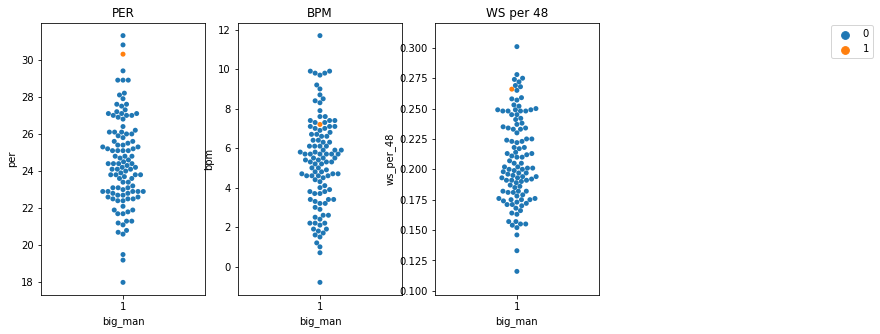

In [11]:
fig, ax =plt.subplots(1,3, sharex=True, figsize=(10,5))
sns.swarmplot(ax=ax[0],x='big_man', y='per', data=big_men, hue='embiid_tag')
sns.swarmplot(ax=ax[1],x='big_man', y='bpm', data=big_men, hue='embiid_tag')
sns.swarmplot(ax=ax[2],x='big_man', y='ws_per_48', data=big_men, hue='embiid_tag')
ax[0].set_title('PER')
ax[1].set_title('BPM')
ax[2].set_title('WS per 48')
ax[1].legend().set_visible(False)
ax[2].legend().set_visible(False)
ax[0].legend(bbox_to_anchor=(5.1, 1.01))

In [12]:
features=['per', 'ts_pct', 'usg_pct', 'bpm', 'g', 'mp_per_g', 'pts_per_g', 'trb_per_g',
       'ast_per_g', 'stl_per_g', 'blk_per_g', 'ws_per_48','team_wins']

training_seasons=['1980-81', '1981-82', '1984-85', '1982-83', '1998-99', '1996-97',
       '1990-91', '1997-98', '1988-89', '2001-02', '1985-86', '2000-01',
       '2007-08', '1991-92', '1993-94', '2006-07', '1986-87', '1995-96',
       '1987-88', '2013-14', '1999-00', '2012-13' , '2003-04',
       '1994-95', '2011-12', '2009-10', '1983-84', '1989-90', '1992-93','2018-19','2002-03']
testing_seasons=['2017-18', '2010-11' , '2014-15', '2008-09', '2005-06',
       '2016-17', '2015-16' , '2019-20','2020-21', '2004-05']

#training data
training_data=mvp_seasons[mvp_seasons['season'].isin(training_seasons)]
train_X=training_data[features]
train_y=training_data['award_share']

#testing data
testing_data=mvp_seasons[mvp_seasons['season'].isin(testing_seasons)]
test_X=testing_data[features]
test_y=testing_data['award_share']

#model
share_model = DecisionTreeRegressor(random_state=1)
share_model.fit(train_X, train_y)
predictions=share_model.predict(test_X)


#put testing data and predictions into new dataframe
predicted_df=pd.DataFrame()
test_Xdf=pd.DataFrame(test_X)

test_Xdf['Prediction']=predictions
test_Xdf['award_share']=test_y
test_Xdf['season']=[mvp_seasons['season'][index] for index in test_Xdf.reset_index()['index']]
test_Xdf['player']=[mvp_seasons['player'][index] for index in test_Xdf.reset_index()['index']]
test_Xdf['mvp_winner']=[mvp_seasons['mvp_winner'][index] for index in test_Xdf.reset_index()['index']]
test_Xdf['embiid_and_mvps']=[mvp_seasons['embiid_and_mvps'][index] for index in test_Xdf.reset_index()['index']]
predicted_df=predicted_df.append(test_Xdf)
   
predicted_df

# What to Expect out of Embiid

#he gets to the line at an elite rate


# How crazy are Matisse's numbers